In [1]:
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)                                     #训练集
y = np.sin(X).ravel()
print(X.shape)

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]             #测试集       #从0到5均分100000个点,[:, None] 表示可以超过默认indice数量
print(X_plot.shape)

(10000, 1)
(100000, 1)


In [3]:
# #############################################################################
# Fit regression model
train_size = 100          #训练集只考虑前100个数据
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,                  #网格调参法，参见GridSearchCV说明
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size     #svr.best_estimator_.support_表示输出支持向量的indice的数列
print("Support vector ratio: %.3f" % sv_ratio)                   #支持向量占总向量的比例

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))

#发现！！！ SVR由于没有显式解拟合较慢，但在预测上由于仅用到支持向量故比KRR快。即KRR计算模型快，预测慢；SVR计算慢，预测快

SVR complexity and bandwidth selected and model fitted in 0.805 s
KRR complexity and bandwidth selected and model fitted in 0.432 s
Support vector ratio: 0.320
SVR prediction for 100000 inputs in 0.100 s
KRR prediction for 100000 inputs in 0.375 s


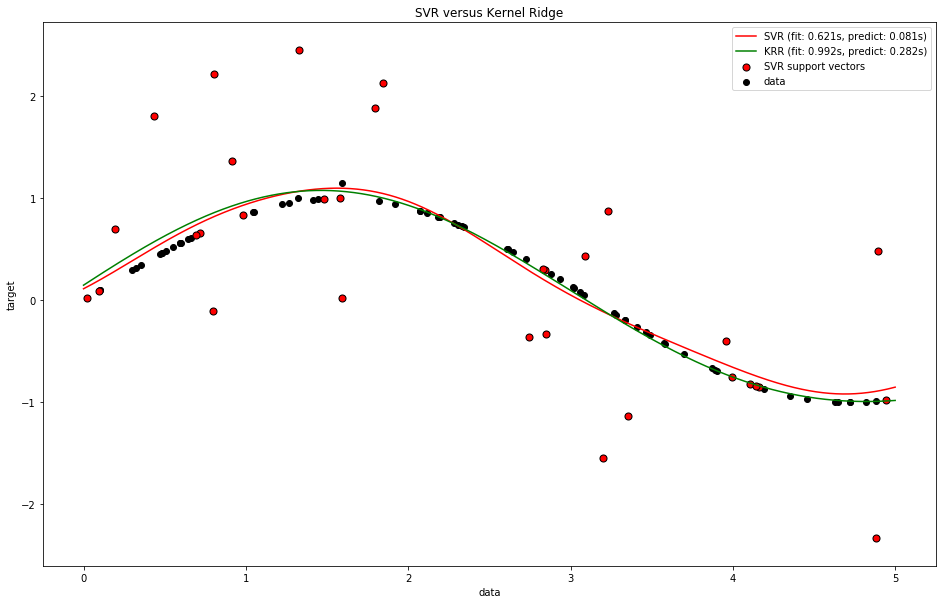

In [4]:
# #############################################################################
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.figure(figsize=(16,10))
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',           #画的sv的点,c='r'为红色
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,   #画的训练集,c='k'为黑色，zorder=1表示散点图放在zorder小于1的其他图的上面
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))         #附上了fit时间和predict时间
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()


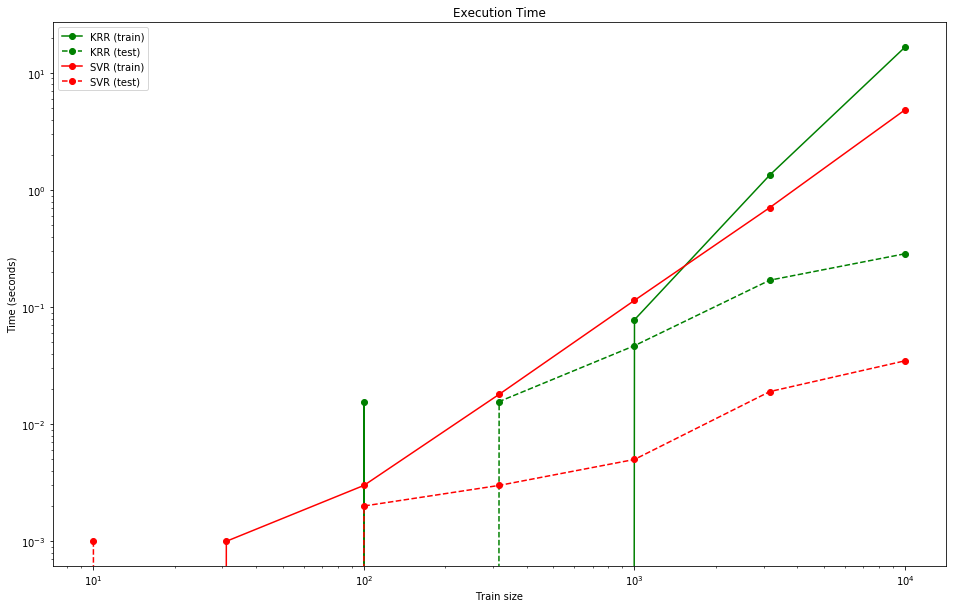

In [4]:
# 对于SVR和KRR，不同样本大小时候的fit时间和predict时间比较     
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))                  #a//3表示a除以3的整数部分
sizes = np.logspace(1, 4, 7).astype(np.int)               #从10^1到10^4总共有7个数

plt.figure(figsize=(16,10))

for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",          #SVR为红色，KRR为绿色
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",          #实线为fit时间比较，虚线为predict时间比较
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

# Visualize learning curves
plt.show()

[ 9 18 27 36 45 54 63 72 81 90]
[ 9 18 27 36 45 54 63 72 81 90]
(10, 10)
(10, 10)


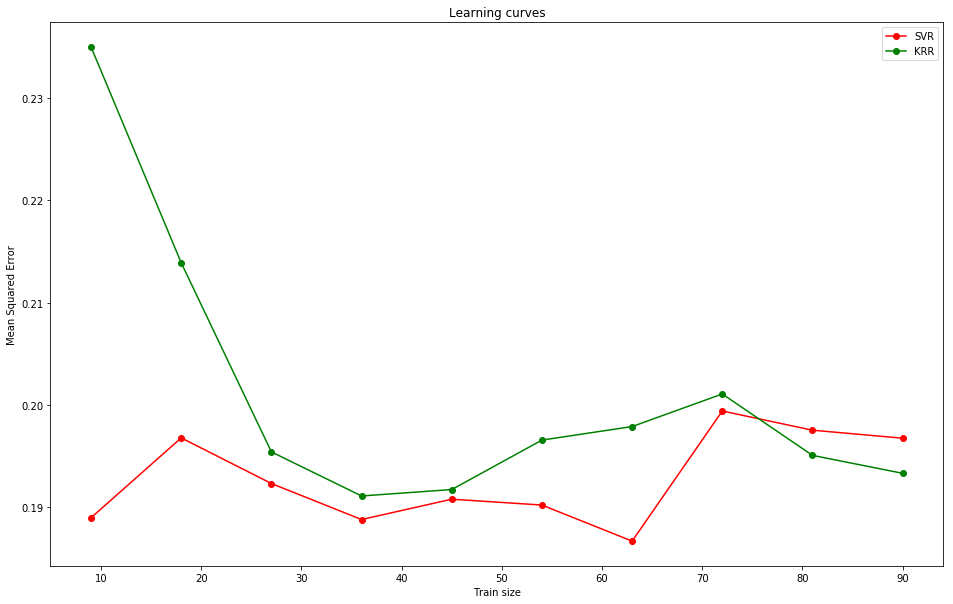

In [14]:
svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),  # X[:100], y[:100]表示100个训练集，
                   scoring="neg_mean_squared_error", cv=10)      #train_sizes=np.linspace(0.1, 1, 10)表示取10次，每次多取10%
                                                                 # cv=10：10-fold cross validation
                                             #输出：train_sizes同输入，train_score和test的dim=train_size的dim*cv的dim，
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

#print(train_sizes)
#print(train_sizes_abs)
#print(train_scores_svr.shape)
#print(test_scores_svr.shape)

plt.figure(figsize=(16,10))
plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",     #用.mean(1)算法对行求平均，输出才是每个size大小对应的test平局得分
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()